In [14]:
from urllib.request import urlopen
import warnings

import cmasher as cmr
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from highlight_text import ax_text

from mplsoccer import Pitch, VerticalPitch, add_image, FontManager, Sbopen

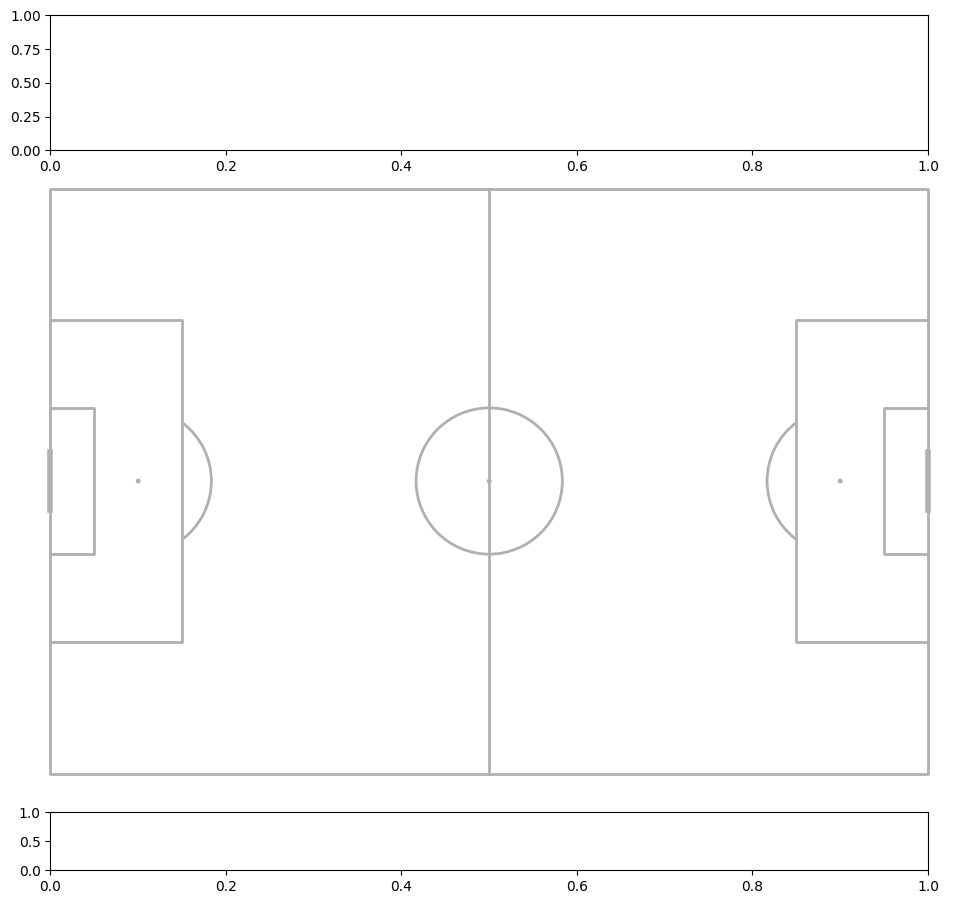

In [15]:
pitch = Pitch()
fig, ax = pitch.grid()

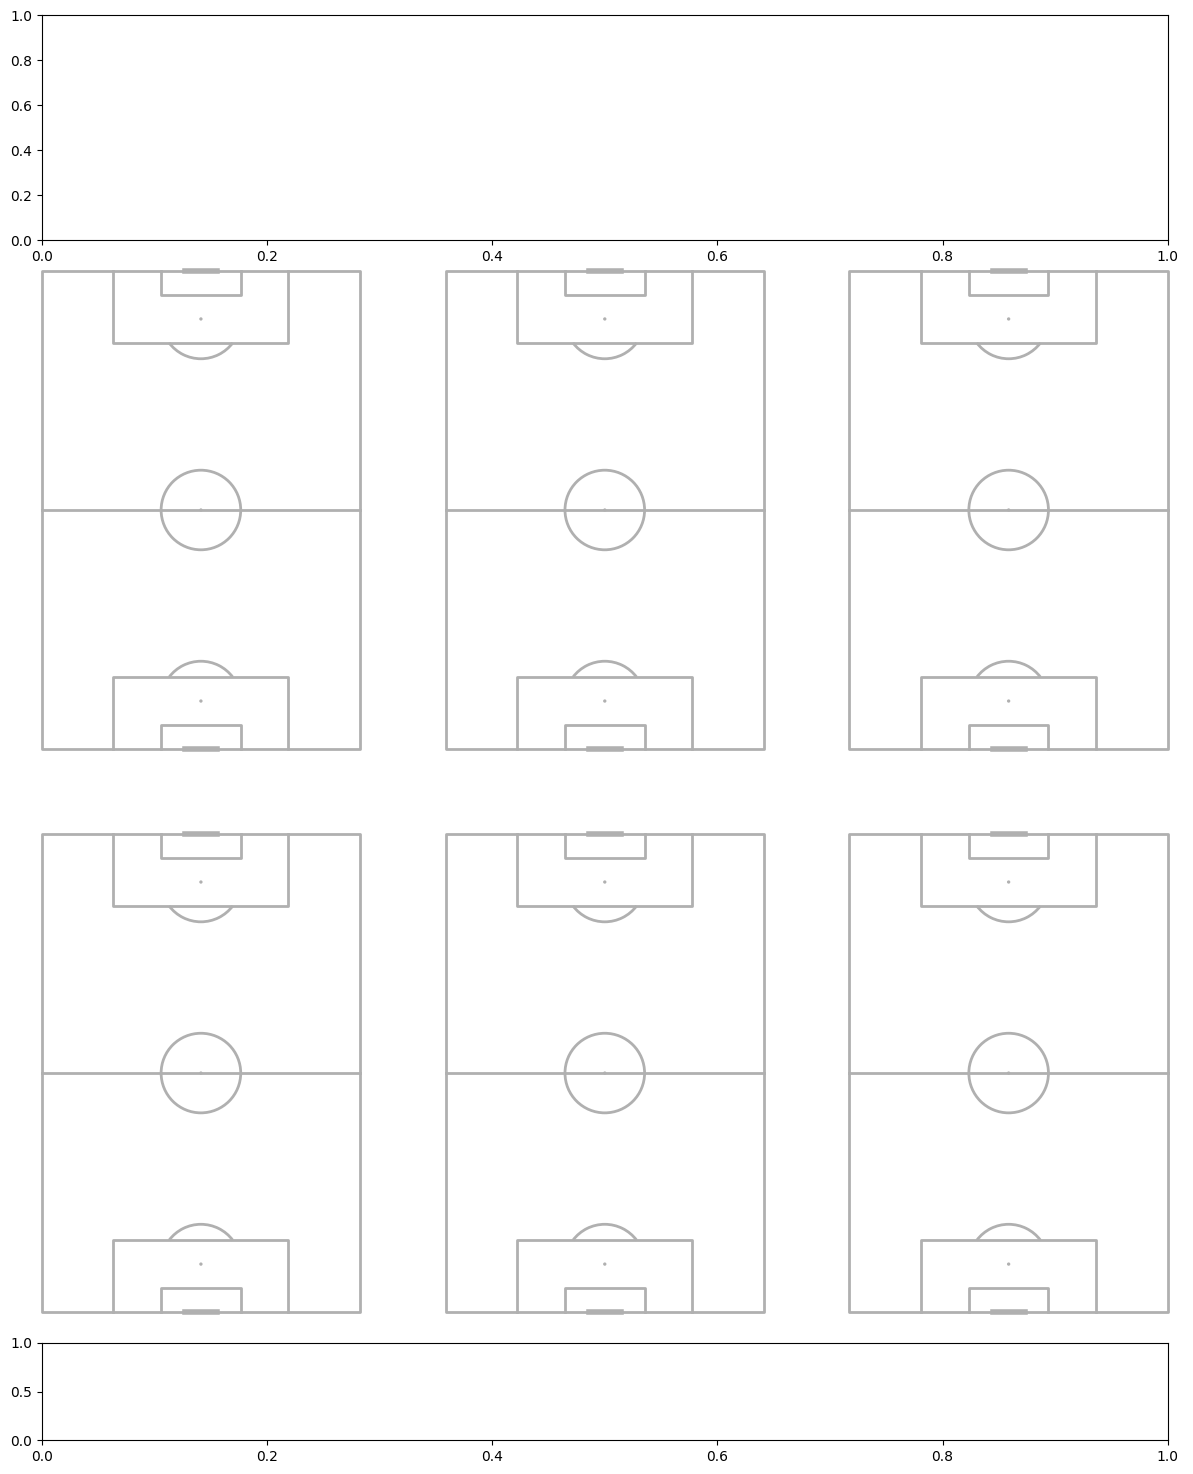

In [17]:
pitch = VerticalPitch()
fig, ax = pitch.grid(figheight=15, ncols=3, nrows=2)

In [18]:
parser = Sbopen()
events, related, freeze, tactics = parser.event(15946)
lineup = parser.lineup(15946)

In [20]:
# dataframe with player_id and when they were subbed off
time_off = events.loc[(events.type_name == 'Substitution'),
                      ['player_id', 'minute']]
time_off.rename({'minute': 'off'}, axis='columns', inplace=True)
# dataframe with player_id and when they were subbed on
time_on = events.loc[(events.type_name == 'Substitution'),
                     ['substitution_replacement_id', 'minute']]
time_on.rename({'substitution_replacement_id': 'player_id',
                'minute': 'on'}, axis='columns', inplace=True)
players_on = time_on.player_id
# merge on times subbed on/off
lineup = lineup.merge(time_on, on='player_id', how='left')
lineup = lineup.merge(time_off, on='player_id', how='left')

,player_id,player_name,player_nickname,jersey_number,match_id,team_id,team_name,country_id,country_name,on_x,off_x,on_y,off_y
0,3109,Malcom Filipe Silva de Oliveira,Malcom,14,15946,217,Barcelona,31,Brazil,NaN,NaN,NaN,NaN
1,3501,Philippe Coutinho Correia,Philippe Coutinho,7,15946,217,Barcelona,31,Brazil,45.0,NaN,45.0,NaN
2,5203,Sergio Busquets i Burgos,Sergio Busquets,5,15946,217,Barcelona,214,Spain,NaN,84.0,NaN,84.0
3,5211,Jordi Alba Ramos,Jordi Alba,18,15946,217,Barcelona,214,Spain,NaN,NaN,NaN,NaN
4,5213,Gerard Piqué Bernabéu,Gerard Piqué,3,15946,217,Barcelona,214,Spain,NaN,NaN,NaN,NaN
5,5246,Luis Alberto Suárez Díaz,Luis Suárez,9,15946,217,Barcelona,242,Uruguay,NaN,NaN,NaN,NaN
6,5470,Ivan Rakitić,Ivan Rakitić,4,15946,217,Barcelona,56,Croatia,NaN,NaN,NaN,NaN
7,5477,Ousmane Dembélé,Ousmane Dembélé,11,15946,217,Barcelona,78,France,NaN,76.0,NaN,76.0
8,5492,Samuel Yves Umtiti,Samuel Umtiti,23,15946,217,Barcelona,78,France,NaN,NaN,NaN,NaN
9,5503,Lionel Andrés Messi Cuccittini,Lionel Messi,10,15946,217,Barcelona,11,Argentina,NaN,NaN,NaN,NaN


In [21]:
# filter the tactics lineup for the starting xi
starting_ids = events[events.type_name == 'Starting XI'].id
starting_xi = tactics[tactics.id.isin(starting_ids)]
starting_players = starting_xi.player_id

# filter the lineup for players that actually played
mask_played = ((lineup.on.notnull()) | (lineup.off.notnull()) |
               (lineup.player_id.isin(starting_players)))
lineup = lineup[mask_played].copy()

# get the first position for each player and add this to the lineup dataframe
player_positions = (events[['player_id', 'position_id']]
                    .dropna(how='any', axis='rows')
                    .drop_duplicates('player_id', keep='first'))
lineup = lineup.merge(player_positions, how='left', on='player_id')

# add on the position abbreviation
formation_dict = {1: 'GK', 2: 'RB', 3: 'RCB', 4: 'CB', 5: 'LCB', 6: 'LB', 7: 'RWB',
                  8: 'LWB', 9: 'RDM', 10: 'CDM', 11: 'LDM', 12: 'RM', 13: 'RCM',
                  14: 'CM', 15: 'LCM', 16: 'LM', 17: 'RW', 18: 'RAM', 19: 'CAM',
                  20: 'LAM', 21: 'LW', 22: 'RCF', 23: 'ST', 24: 'LCF', 25: 'SS'}
lineup['position_abbreviation'] = lineup.position_id.map(formation_dict)

# sort the dataframe so the players are
# in the order of their position (if started), otherwise in the order they came on
lineup['start'] = lineup.player_id.isin(starting_players)
lineup.sort_values(['team_name', 'start', 'on', 'position_id'],
                   ascending=[True, False, True, True], inplace=True)

AttributeError: 'DataFrame' object has no attribute 'on'

In [22]:
# add padding to the top so we can plot the titles, and raise the pitch lines
pitch = Pitch(pad_top=10, line_zorder=2)

# arrow properties for the sub on/off
green_arrow = dict(arrowstyle='simple, head_width=0.7',
                   connectionstyle="arc3,rad=-0.8", fc="green", ec="green")
red_arrow = dict(arrowstyle='simple, head_width=0.7',
                 connectionstyle="arc3,rad=-0.8", fc="red", ec="red")

# a fontmanager object for using a google font
fm_scada = FontManager('https://raw.githubusercontent.com/googlefonts/scada/main/fonts/ttf/'
                       'Scada-Regular.ttf')

# Load the Club/ Statsbomb logos
# these are the property of the respective clubs/ StatsBomb.
BARCA_LOGO_URL = ('https://upload.wikimedia.org/wikipedia/en/thumb/4/47/'
                  'FC_Barcelona_%28crest%29.svg/142px-FC_Barcelona_%28crest%29.svg.png')
DEPORTIVO_LOGO_URL = ('https://upload.wikimedia.org/wikipedia/en/thumb/f/f8/'
                      'Deportivo_Alaves_logo_%282020%29.svg/'
                      '300px-Deportivo_Alaves_logo_%282020%29.svg.png')
SB_LOGO_URL = ('https://raw.githubusercontent.com/statsbomb/open-data/'
               'master/img/SB%20-%20Icon%20Lockup%20-%20Colour%20positive.png')
barca_logo = Image.open(urlopen(BARCA_LOGO_URL))
deportivo_logo = Image.open(urlopen(DEPORTIVO_LOGO_URL))
sb_logo = Image.open(urlopen(SB_LOGO_URL))

NameError: name 'num_players' is not defined

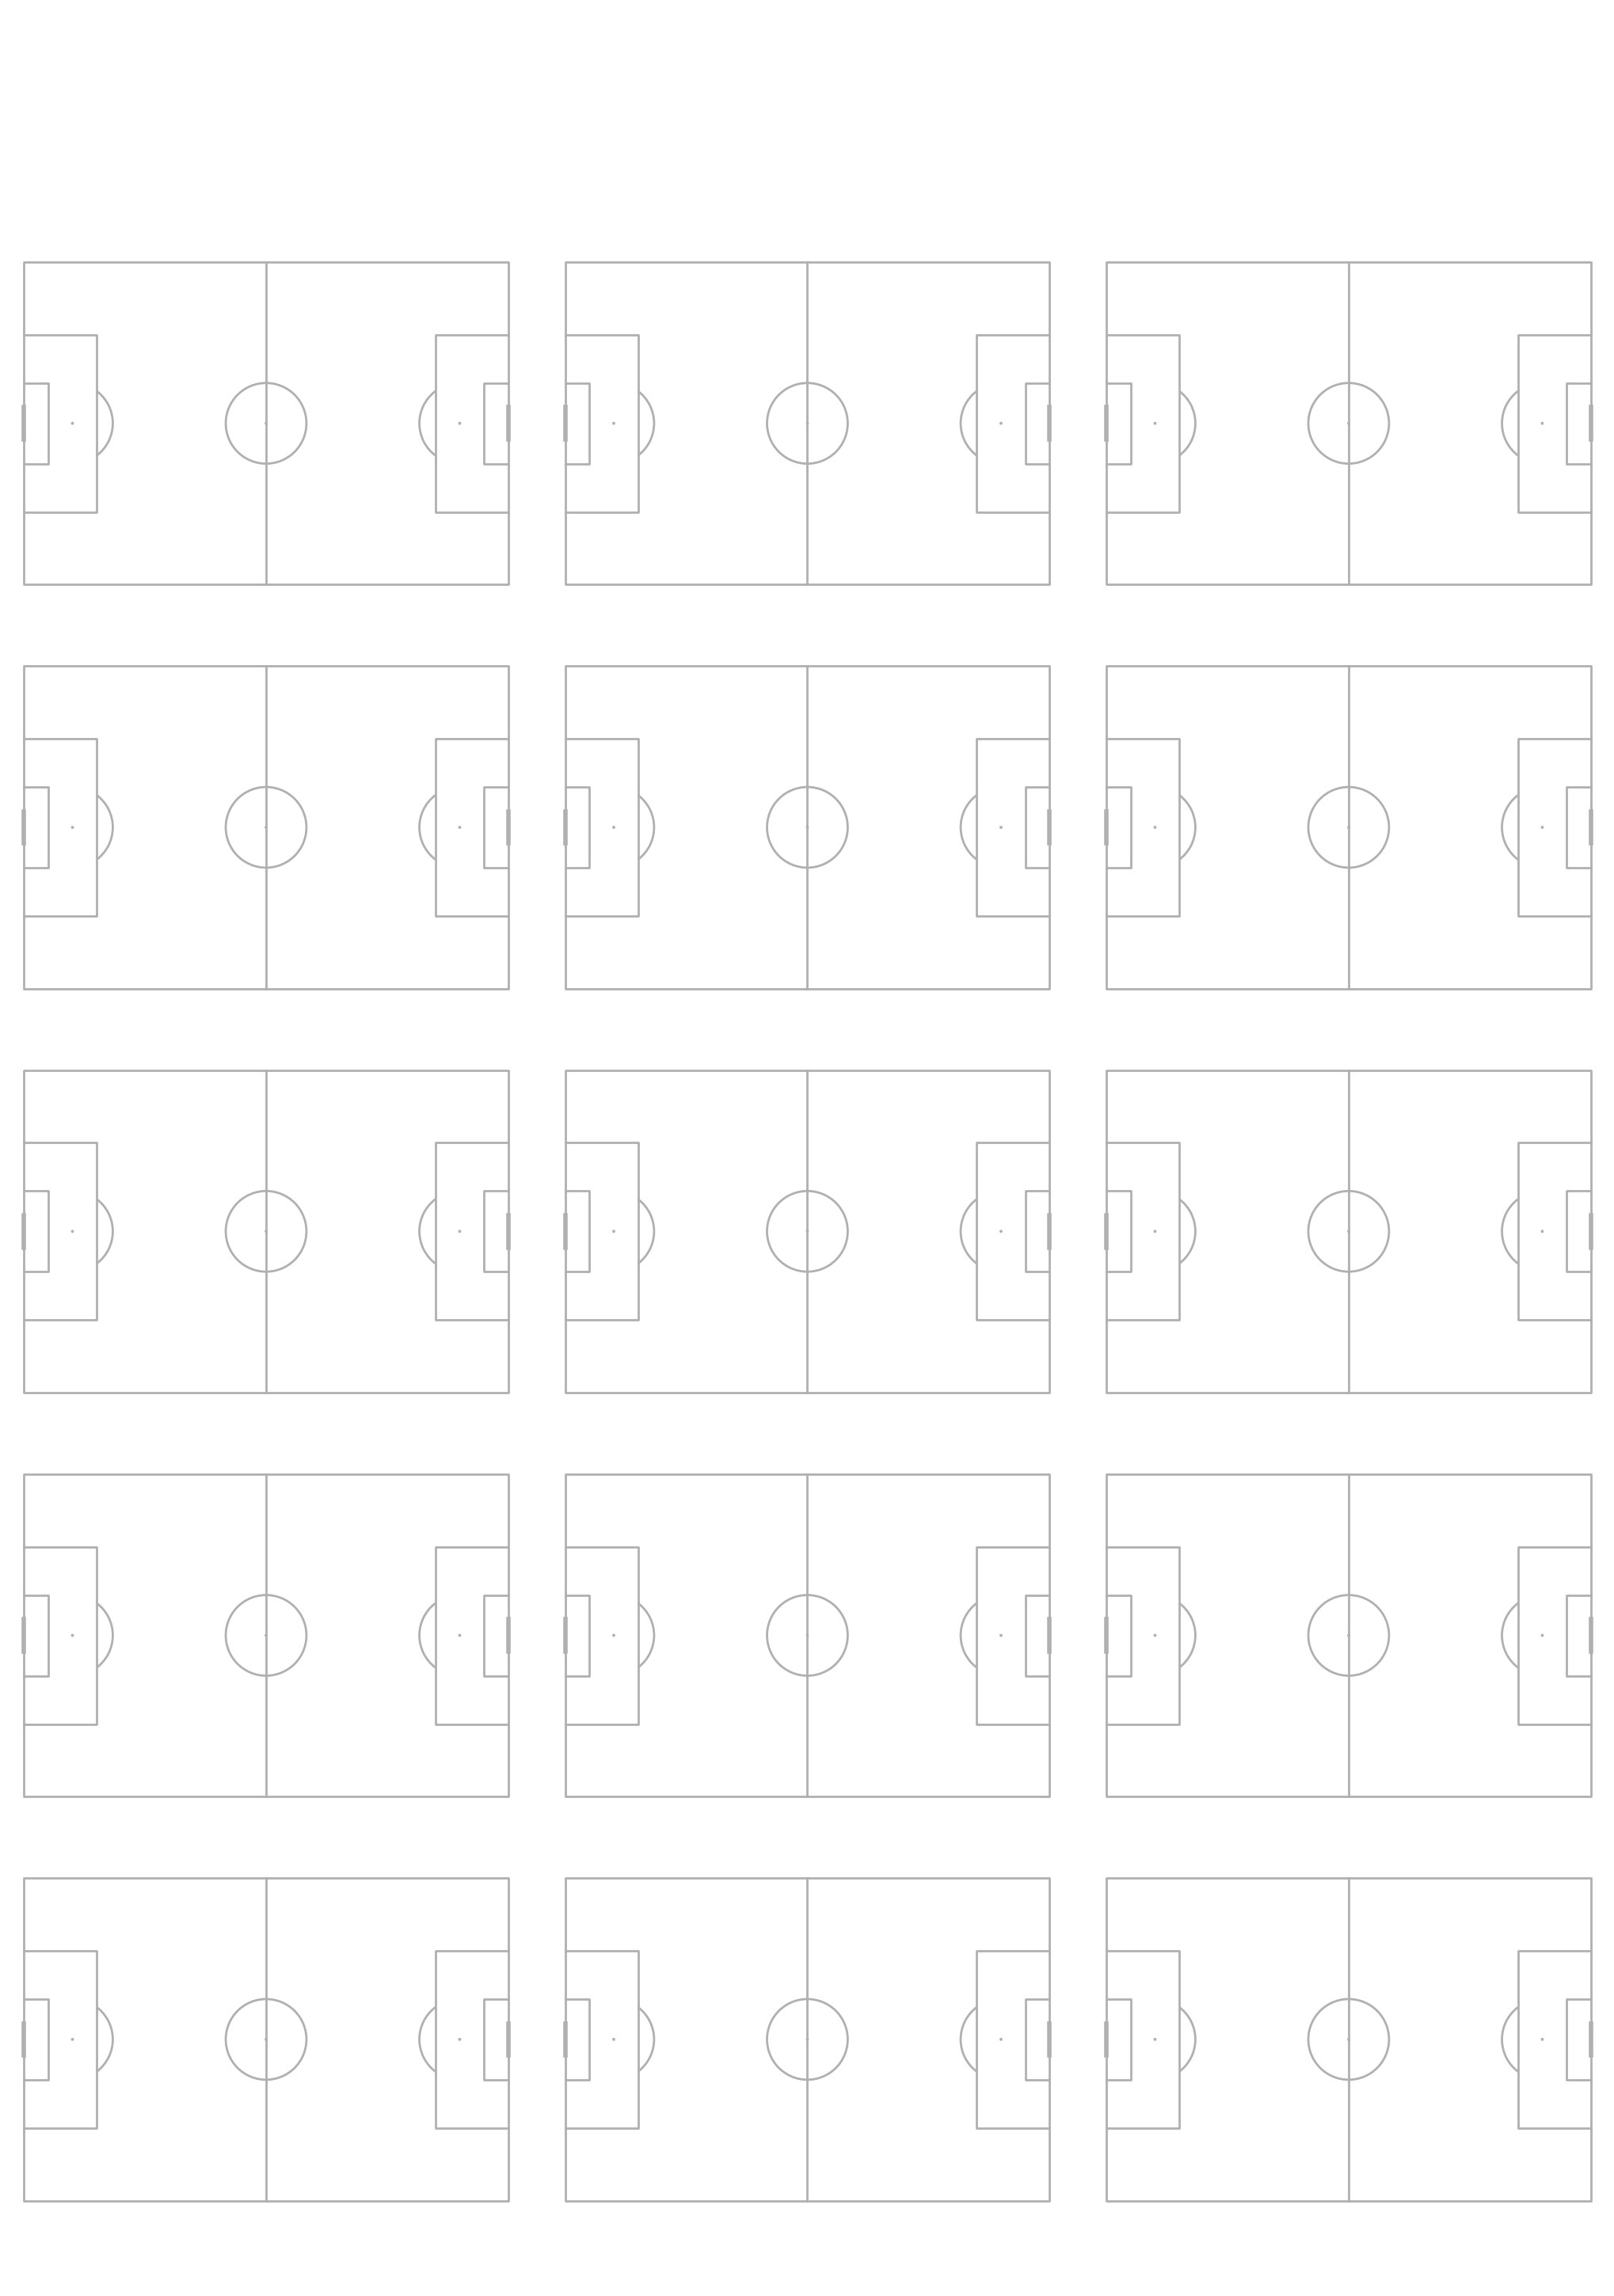

In [23]:
# filtering out some highlight_text warnings - the warnings aren't correct as the
# text fits inside the axes.
warnings.simplefilter("ignore", UserWarning)

# plot the 5 * 3 grid
fig, axs = pitch.grid(nrows=5, ncols=3, figheight=30,
                      endnote_height=0.03, endnote_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      title_height=0.08, grid_height=0.84)
# cycle through the grid axes and plot the player pass maps
for idx, ax in enumerate(axs['pitch'].flat):
    # only plot the pass maps up to the total number of players
    if idx < num_players:
        # filter the complete/incomplete passes for each player (excudes throw-ins)
        lineup_player = lineup_team.iloc[idx]
        player_id = lineup_player.player_id
        player_pass = passes_excl_throw[passes_excl_throw.player_id == player_id]
        complete_pass = player_pass[player_pass.outcome_name.isnull()]
        incomplete_pass = player_pass[player_pass.outcome_name.notnull()]

        # plot the arrows
        pitch.arrows(complete_pass.x, complete_pass.y,
                     complete_pass.end_x, complete_pass.end_y,
                     color='#56ae6c', width=2, headwidth=4, headlength=6, ax=ax)
        pitch.arrows(incomplete_pass.x, incomplete_pass.y,
                     incomplete_pass.end_x, incomplete_pass.end_y,
                     color='#7065bb', width=2, headwidth=4, headlength=6, ax=ax)

        # plot the title for each player axis
        # here we use f-strings to combine the variables from the dataframe and text
        # we plot the title at x=0, y=-5
        # this is the left hand-side of the pitch (x=0) and between
        # top of the y-axis (y=0) and the top of the padding (y=-10, remember pad_top = 10)
        # note that the StatsBomb y-axis is inverted, so you may need
        # to change this if you use another pitch_type (e.g. 'uefa').
        # We also use the highlight-text package to highlight complete_pass green
        # so put <> around the number of completed passes.
        total_pass = len(complete_pass) + len(incomplete_pass)
        annotation_string = (f'{lineup_player.position_abbreviation} | '
                             f'{lineup_player.player_name} | '
                             f'<{len(complete_pass)}>/{total_pass} | '
                             f'{round(100 * len(complete_pass)/total_pass, 1)}%')
        ax_text(0, -5, annotation_string, ha='left', va='center', fontsize=13,
                fontproperties=fm_scada.prop,  # using the fontmanager for the google font
                highlight_textprops=[{"color": '#56ae6c'}], ax=ax)

        # add information for subsitutions on/off and arrows
        if not np.isnan(lineup_team.iloc[idx].off):
            ax.text(116, -10, str(lineup_team.iloc[idx].off.astype(int)), fontsize=20,
                    fontproperties=fm_scada.prop,
                    ha='center', va='center')
            ax.annotate('', (120, -2), (112, -2), arrowprops=red_arrow)
        if not np.isnan(lineup_team.iloc[idx].on):
            ax.text(104, -10, str(lineup_team.iloc[idx].on.astype(int)), fontsize=20,
                    fontproperties=fm_scada.prop,
                    ha='center', va='center')
            ax.annotate('', (108, -2), (100, -2), arrowprops=green_arrow)

# plot on the last Pass Map
# (note ax=ax as we have cycled through to the last axes in the loop)
pitch.kdeplot(x=pass_receipts.x, y=pass_receipts.y, ax=ax,
              cmap=cmr.lavender,
              levels=100,
              thresh=0, fill=True)
ax.text(0, -5, f'{team}: Pass Receipt Heatmap', ha='left', va='center',
        fontsize=20, fontproperties=fm_scada.prop)

# remove unused axes (if any)
for ax in axs['pitch'].flat[11 + num_sub:-1]:
    ax.remove()

# endnote text
axs['endnote'].text(0, 0.5, 'The format is copied from @DymondFormation',
                    fontsize=20, fontproperties=fm_scada.prop, va='center', ha='left')
# to get the left position to align with the pitches I plotted it once with a random
# left position (e.g. 0.5) and then used the following code
# bbox_sb = ax_sb_logo.get_position()
# bbox_endnote = axs['endnote'].get_position()
# left = bbox_endnote.x1 - bbox_sb.width
ax_sb_logo = add_image(sb_logo, fig, left=0.701126,
                       # set the bottom and height to align with the endnote
                       bottom=axs['endnote'].get_position().y0,
                       height=axs['endnote'].get_position().height)

# title text
axs['title'].text(0.5, 0.65, f'{team1} Pass Maps vs {team2}', fontsize=40,
                  fontproperties=fm_scada.prop, va='center', ha='center')
SUB_TEXT = ('Player Pass Maps: exclude throw-ins only\n'
            'Team heatmap: includes all attempted pass receipts')
axs['title'].text(0.5, 0.35, SUB_TEXT, fontsize=20,
                  fontproperties=fm_scada.prop, va='center', ha='center')
# plot logos (same height as the title_ax)
# set the barca logo to align with the left/bottom of the title axes
ax_barca_logo = add_image(barca_logo, fig,
                          left=axs['title'].get_position().x0,
                          bottom=axs['title'].get_position().y0,
                          height=axs['title'].get_position().height)
# set the deportivo logo to align with the right/bottom of the title axes
# to get the left position to align with the pitches I plotted it once with a random
# left position (e.g. 0.5) and then used the following code
# bbox_logo = ax_deportivo_logo.get_position()
# bbox_title = axs['title'].get_position()
# left = bbox_title.x1 - bbox_logo.width
ax_deportivo_logo = add_image(deportivo_logo, fig, left=0.8521,
                              bottom=axs['title'].get_position().y0,
                              height=axs['title'].get_position().height)
# setting this example to the gallery thumbnail
# sphinx_gallery_thumbnail_path = 'gallery/pitch_plots/images/sphx_glr_plot_grid_005'

plt.show()  # If you are using a Jupyter notebook you do not need this line